In [1]:
# ======================================================================
# 1. INSTALASI DEPENDENSI
# ======================================================================
# Pastikan semua library yang dibutuhkan sudah terpasang.
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow tensorflow-hub kagglehub ipywidgets keras-cv --quiet

In [2]:
# ======================================================================
# 2. IMPORT LIBRARY
# ======================================================================
# Mengimpor semua modul yang akan digunakan dalam pipeline.
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import kagglehub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [3]:
# ======================================================================
# 3. UNDUH DATASET
# ======================================================================
# Mengunduh dataset dari Kaggle. Pastikan Anda telah mengonfigurasi API Kaggle
# di lingkungan Anda jika belum pernah melakukannya (misalnya dengan mengunggah kaggle.json).

dataset_dir = "./input/plant-disease-dataset"
zip_path = os.path.join(dataset_dir, "plant-disease-dataset-v2-1-0.zip")

# Membuat direktori jika belum ada
os.makedirs(dataset_dir, exist_ok=True)

# Mengunduh dataset hanya jika belum ada
if not os.path.exists(os.path.join(dataset_dir, "dataset-3-splite-and-augmented")):
    print("Mengunduh dataset dari Kaggle...")
    # Anda mungkin perlu login jika ini pertama kali
    # kagglehub.login()
    !kaggle datasets download -d vargheeskuttyeldhose/plant-disease-dataset-v2-1-0 -p {dataset_dir} --unzip
    print("✅ Dataset berhasil diunduh dan diekstrak.")
else:
    print("✅ Dataset sudah tersedia secara lokal.")

# Tampilkan isi direktori
print(f"\nDataset tersedia di: {dataset_dir}")
print("📝 Daftar isi:")
print(os.listdir(dataset_dir))

✅ Dataset sudah tersedia secara lokal.

Dataset tersedia di: ./input/plant-disease-dataset
📝 Daftar isi:
['dataset-3-splite-and-augmented']


In [4]:
# ======================================================================
# 4. PERSIAPAN DATA (DATA PREPARATION)
# ======================================================================
# Menyiapkan generator data untuk training, validasi, dan testing.
# Augmentasi data diterapkan pada data training untuk meningkatkan generalisasi model.

# Direktori utama setelah diekstrak
base_dir = os.path.join(dataset_dir, "dataset-3-splite-and-augmented")

train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

# Parameter
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64

# Generator untuk data training dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Generator untuk data validasi dan test (hanya rescale)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Membuat generator dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=1, # Batch size 1 untuk evaluasi dan prediksi individual
    class_mode='categorical',
    shuffle=False
)

# Simpan nama-nama kelas untuk visualisasi nanti
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"\nTotal kelas yang ditemukan: {num_classes}")

Found 26641 images belonging to 89 classes.
Found 5730 images belonging to 89 classes.
Found 5701 images belonging to 89 classes.

Total kelas yang ditemukan: 89


In [12]:
import json

# ======================================================================
# 4.1. SIMPAN NAMA KELAS
# ======================================================================
# Menyimpan daftar nama kelas ke dalam file JSON. 
# Ini adalah praktik terbaik untuk memastikan konsistensi antara training dan deployment.

class_names_list = list(train_generator.class_indices.keys())

with open('class_names.json', 'w') as f:
    json.dump(class_names_list, f)

print(f"✅ Nama kelas berhasil disimpan ke 'class_names.json' ({len(class_names_list)} kelas).")

✅ Nama kelas berhasil disimpan ke 'class_names.json' (89 kelas).


In [5]:
# ======================================================================
# 5. DEFINISI LAYER KUSTOM (SERIALIZABLE)
# ======================================================================
# Ini adalah perbaikan krusial. Layer ini membungkus model dari TF-Hub
# dan dirancang agar bisa disimpan dan dimuat kembali oleh Keras.

@tf.keras.utils.register_keras_serializable()
class FeatureExtractorLayer(keras.layers.Layer):
    def __init__(self, model_handle, trainable=False, **kwargs):
        super().__init__(**kwargs)
        self.model_handle = model_handle
        self.trainable = trainable
        self._hub_layer = hub.KerasLayer(
            self.model_handle,
            trainable=self.trainable
        )

    def call(self, inputs):
        return self._hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "model_handle": self.model_handle,
            "trainable": self.trainable
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [6]:
# ======================================================================
# 6. MEMBANGUN MODEL (MODEL BUILDING)
# ======================================================================
# Membangun arsitektur model menggunakan transfer learning dari EfficientNetV2.

# Handle model dari TensorFlow Hub
model_handle = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1"

inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Layer base (feature extractor) dari layer kustom kita
x = FeatureExtractorLayer(model_handle=model_handle, trainable=False)(inputs)

# Classification head
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Layer output, gunakan dtype='float32' untuk menghindari masalah presisi
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = keras.Model(inputs, outputs)

# Tampilkan ringkasan arsitektur model
print("\nArsitektur Model:")
model.summary()


Arsitektur Model:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 feature_extractor_layer (F  (None, 1536)              12930622  
 eatureExtractorLayer)                                           
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)  

In [7]:
# ======================================================================
# 7. COMPILE DAN TRAINING MODEL
# ======================================================================
# Mengompilasi model dengan optimizer, loss, dan metrics, lalu melatihnya.

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training
print("\nMemulai proses training model...")
history = model.fit(
    train_generator,
    epochs=5, # Jumlah epoch bisa disesuaikan, 25 adalah awal yang baik
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)
print("✅ Training selesai.")


Memulai proses training model...
Epoch 1/5
417/417 [==============================] - 990s 2s/step - loss: 1.5048 - accuracy: 0.6166 - val_loss: 0.4144 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 2/5
417/417 [==============================] - 1271s 3s/step - loss: 0.5620 - accuracy: 0.8238 - val_loss: 0.3309 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 3/5
417/417 [==============================] - 983s 2s/step - loss: 0.4346 - accuracy: 0.8571 - val_loss: 0.2464 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 4/5
417/417 [==============================] - 952s 2s/step - loss: 0.3773 - accuracy: 0.8750 - val_loss: 0.2163 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 5/5
417/417 [==============================] - 966s 2s/step - loss: 0.3450 - accuracy: 0.8835 - val_loss: 0.2236 - val_accuracy: 0.9201 - lr: 0.0010
✅ Training selesai.


In [8]:
# ======================================================================
# 8. SIMPAN MODEL HASIL TRAINING
# ======================================================================
# Menyimpan model dalam format .keras yang modern dan efisien.
model_filename = "leaf_disease_classifier.keras"
model.save(model_filename)
print(f"\n✅ Model berhasil disimpan sebagai '{model_filename}'")


✅ Model berhasil disimpan sebagai 'leaf_disease_classifier.keras'


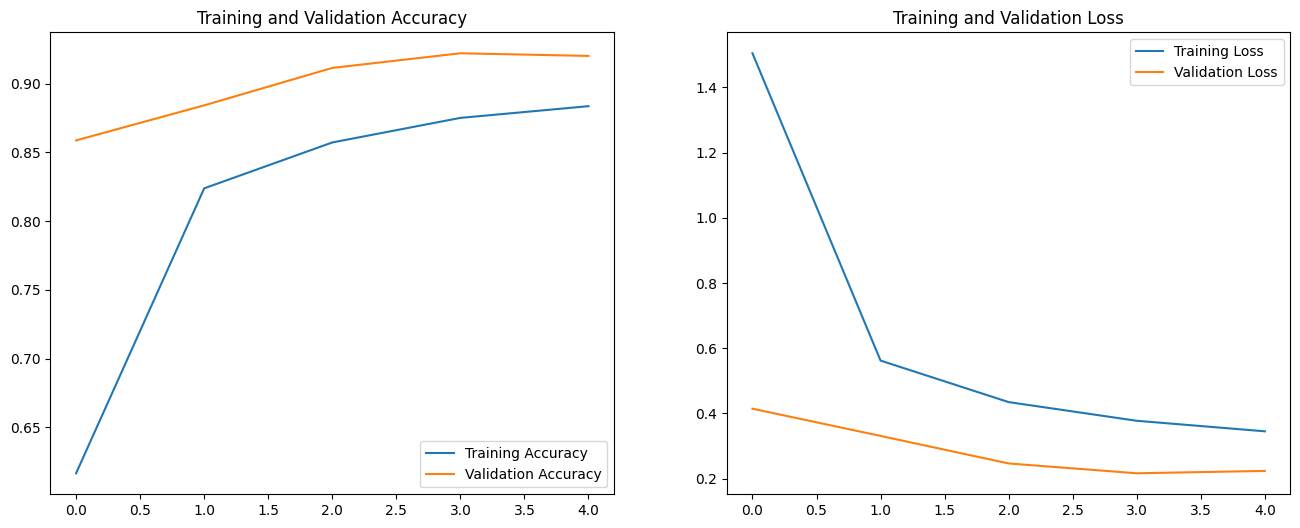

In [9]:
# ======================================================================
# 9. VISUALISASI HASIL TRAINING
# ======================================================================
# Membuat plot akurasi dan loss untuk memantau performa model.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Mengevaluasi model pada data test...
5701/5701 [==============================] - 436s 77ms/step - loss: 0.2030 - accuracy: 0.9214

Akurasi pada data test: 0.9214
Loss pada data test: 0.2030
5701/5701 [==============================] - 463s 81ms/step

Classification Report:
                                             precision    recall  f1-score   support

                               Anthrax Leaf       0.82      1.00      0.90        75
                           Apple-Apple_scab       0.94      1.00      0.97        75
                            Apple-Black_rot       0.99      0.99      0.99        75
                     Apple-Cedar_apple_rust       1.00      0.92      0.96        75
                              Apple-healthy       1.00      0.97      0.99        75
                      Banana-Black_Sigatoka       0.83      0.68      0.75        22
                  Banana-Bract_Mosaic_Virus       1.00      0.91      0.95        22
                             Banana-Healthy

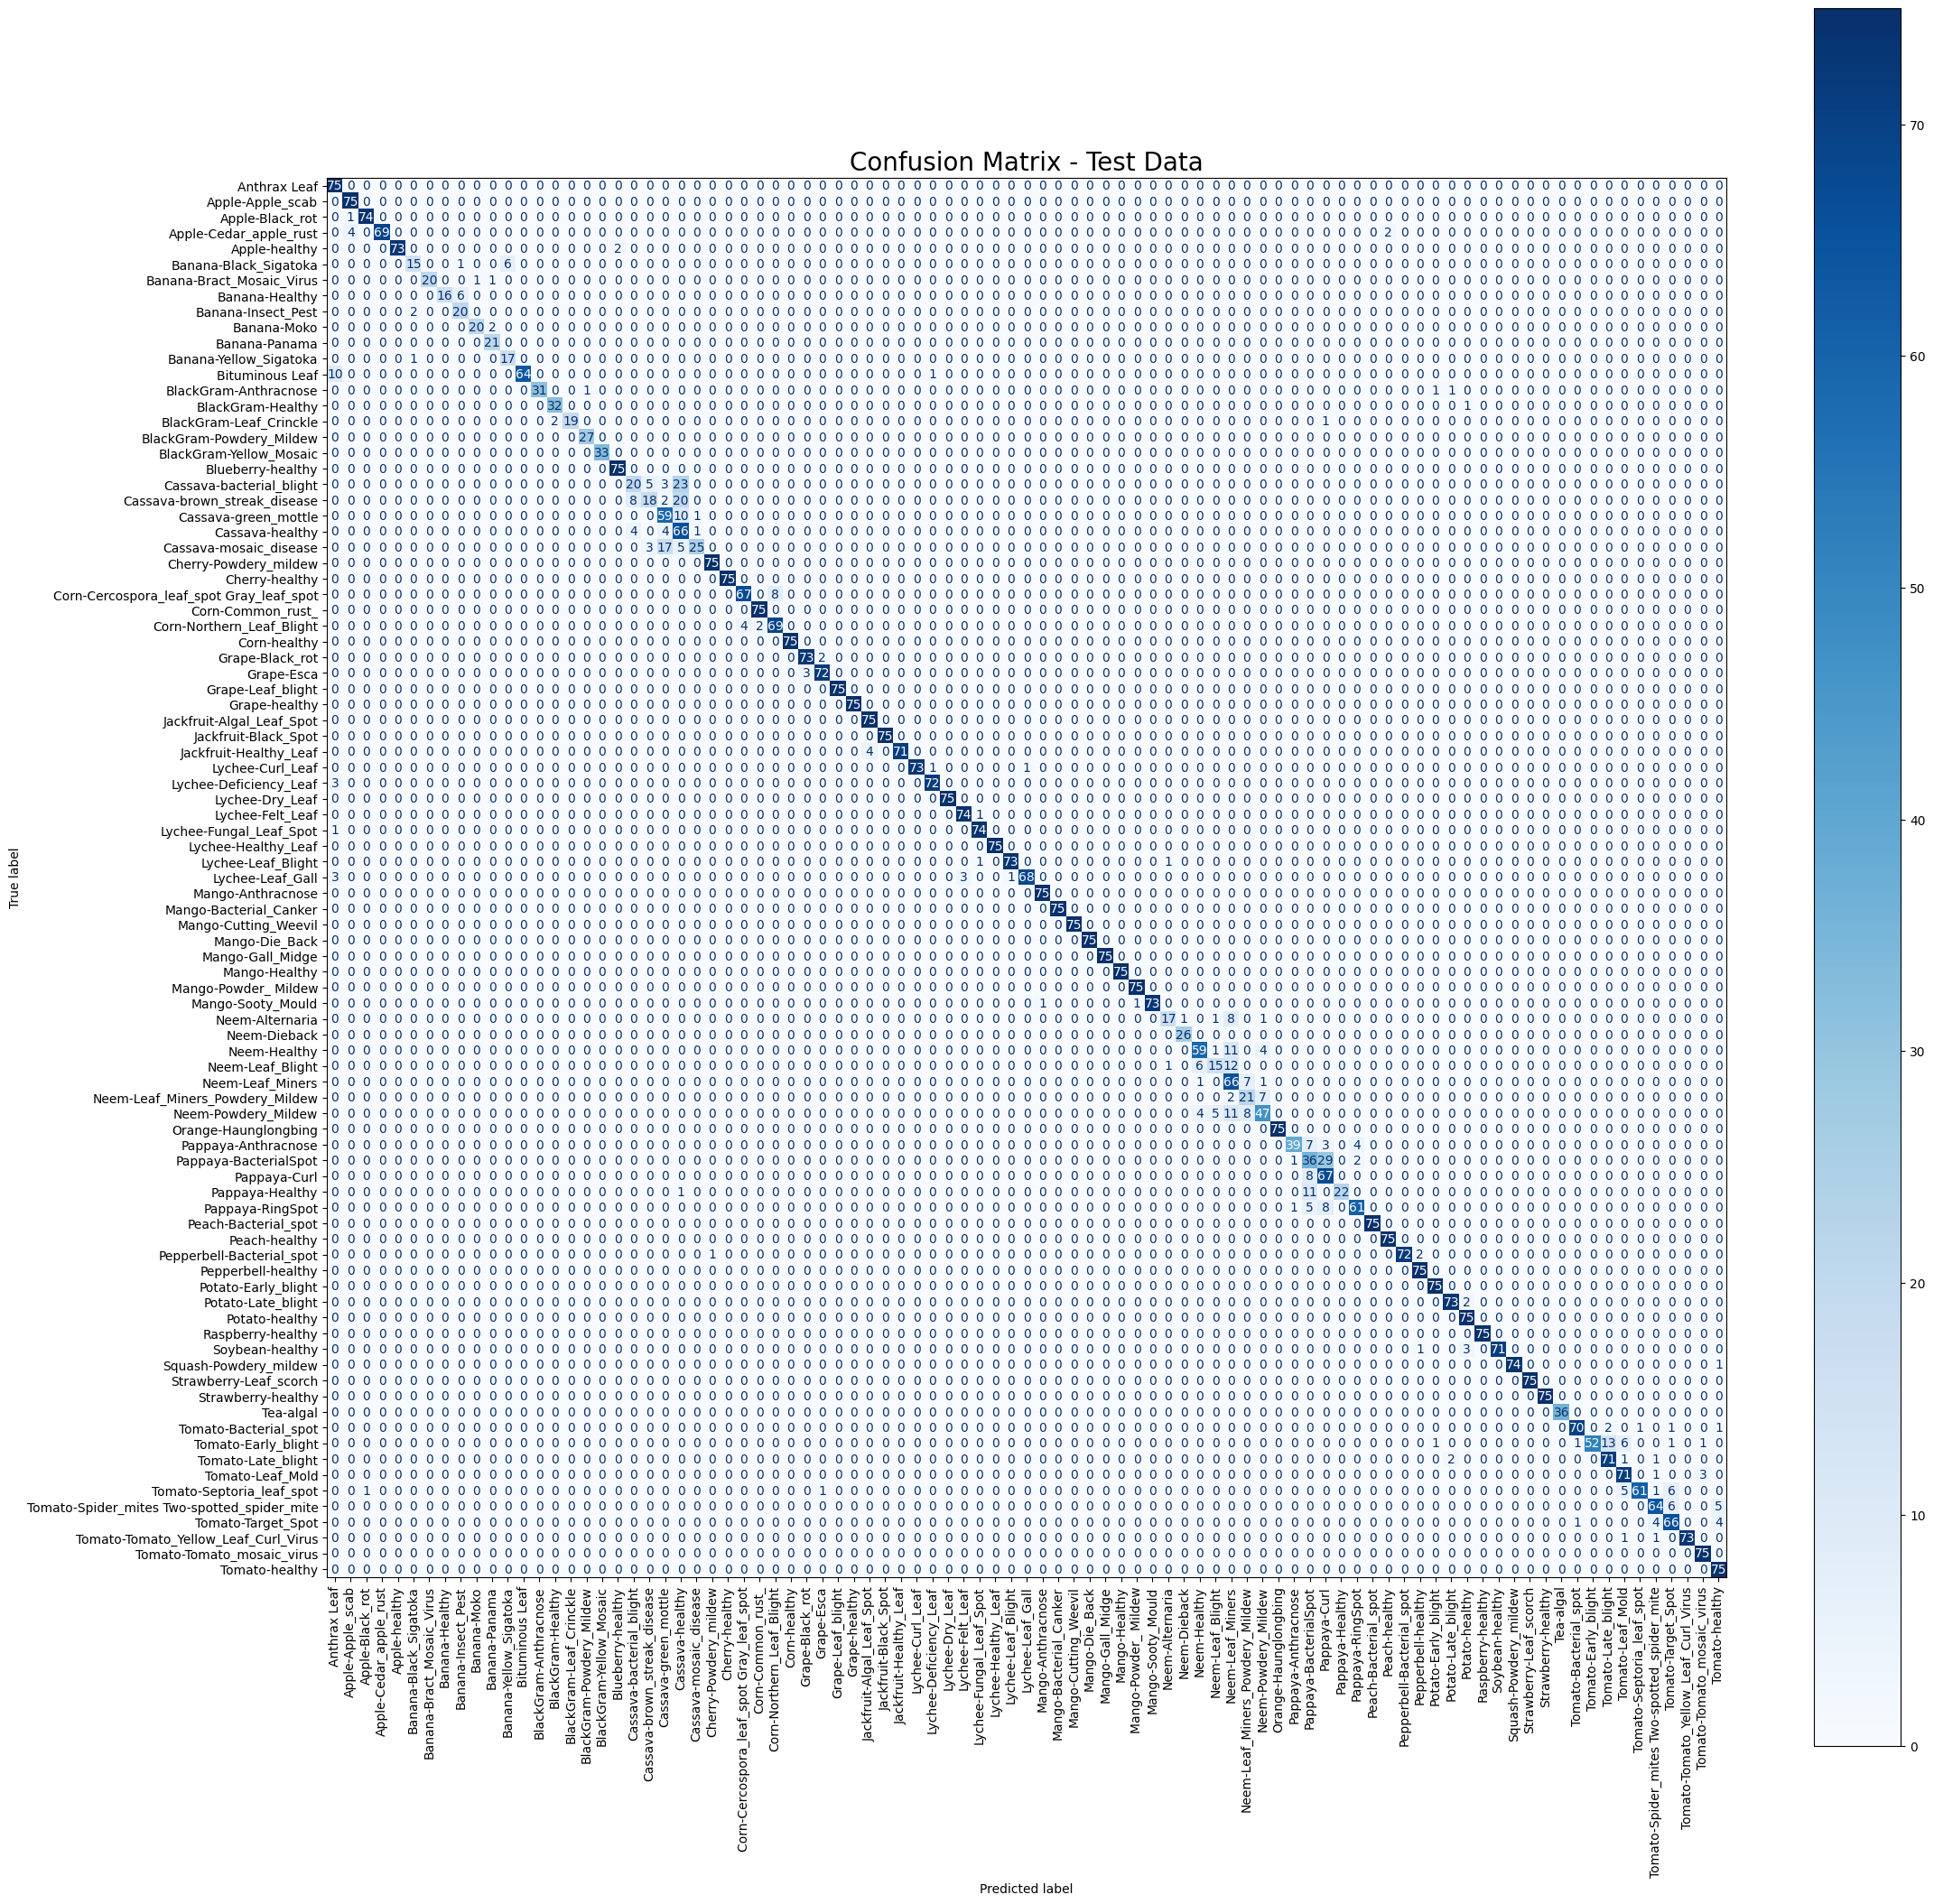

In [10]:
# ======================================================================
# 10. EVALUASI MODEL PADA DATA TEST
# ======================================================================
# Mengukur performa final model pada data yang belum pernah dilihat sebelumnya.
print("\nMengevaluasi model pada data test...")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\nAkurasi pada data test: {test_acc:.4f}")
print(f"Loss pada data test: {test_loss:.4f}")

# Prediksi untuk membuat confusion matrix
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(25, 25)) # Ukuran disesuaikan untuk banyak kelas
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix - Test Data", size=20)
plt.show()


Memuat kembali model dari file 'leaf_disease_classifier.keras'...


✅ Model berhasil dimuat.
1/1 [==============================] - 1s 910ms/step


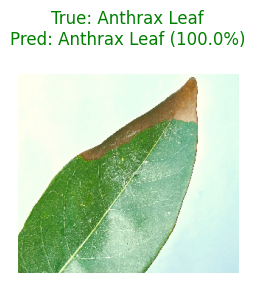

In [11]:
# ======================================================================
# 11. MUAT MODEL & CONTOH PREDIKSI (INFERENCE)
# ======================================================================
# Menunjukkan cara memuat kembali model yang sudah disimpan dan menggunakannya.
print(f"\nMemuat kembali model dari file '{model_filename}'...")

try:
    # Karena layer kustom sudah terdaftar, Keras bisa memuatnya secara otomatis
    loaded_model = keras.models.load_model(model_filename)
    print("✅ Model berhasil dimuat.")
    
    # Ambil beberapa gambar dari test generator untuk prediksi
    images, labels = next(iter(test_generator))
    
    # Lakukan prediksi
    predictions = loaded_model.predict(images)
    
    # Tampilkan hasil
    plt.figure(figsize=(20, 10))
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        
        true_label = class_names[np.argmax(labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100
        
        title_color = 'g' if true_label == pred_label else 'r'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)", color=title_color)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Gagal memuat model. Error: {e}")